In [1]:
import geopandas as gpd
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import json
from shapely.geometry import Polygon, Point
from scipy.interpolate import griddata
import numpy as np
import requests
import io
from datetime import date
import ipywidgets as widgets
from ipywidgets import interact
# **Below needed to run ipywidgets animation locally**
# alt.renderers.enable('default')
alt.renderers.enable('png')

RendererRegistry.enable('png')

#### Load information about sensor sites (names, locations).

In [2]:
# Load site information
sites = pd.read_csv('../data/raw/PM25HR_SITELIST_2020-12-31.csv')
sites.astype({'site': 'str'})

# Add locations of air quality stations in lat/long
sites_wr = sites.groupby(['site', 'name']).aggregate({'latitude':'mean',
                                            'longitude':'mean'}).reset_index()
# Cast 'site' column as a string to match data df
sites_wr['site'] = sites_wr['site'].astype('int').astype('str')

# Load geojson to dataframe object (basemap)
gdf = gpd.read_file('../data/raw/Bay_Area_Counties.geojson')

#### Load the PM 2.5 hourly data from the Calfornia Air Resources Board website's open API. We'll download data from 2020-2-15 through the present day.

In [3]:
# Choose pollutant
param = 'PM25HR' 

# Current date
today = date.today()

# Set parameters
first_date = '2020-2-15' # yyyy-m-d 
units = {'OZONE': '007', 'BC': '001', 'NOX': '007', 'PM25HR': '001'}
year = '2020'
mon = str(today.month)
day = str(today.day)
basin = 'SFB-San+Francisco+Bay'
rows = {'OZONE': '20', 'BC': '6', 'NOX': '18', 'PM25HR': '17'}
fname = param+'_'+year+'-'+mon+'-'+day

url = 'https://www.arb.ca.gov/aqmis2/display.php?sitelist=All&filefmt=csv&\
fname='+fname+'&datafmt=web&download=y&first_date='+first_date+'&\
param='+param+'&units='+units[param]+'&year='+year+'&report=PICKDATA&mon='+mon+'&day='+day+'&o3area=&o3pa8=&\
county_name=--COUNTY--&latitude=--PART+OF+STATE--&basin='+basin+'&\
order=basin%2Ccounty_name%2Cs.name&ptype=aqd&o3switch=new&hours=all&statistic=&\
qselect=Screened&start_mon=2&start_day=1&submit=All+Sites&rows='+rows[param]

r = requests.post(url)
if r.ok:
    data = r.content.decode('utf8')
    pm25_data = pd.read_csv(io.StringIO(data))    

# Remove observations marked "invalid"
pm25_data = pm25_data.dropna()

# Map latitude, longitude values to new columns in data df based on site id
lat_dict = dict(zip(sites_wr['site'], sites_wr['latitude']))
long_dict = dict(zip(sites_wr['site'], sites_wr['longitude']))
pm25_data['lat'] = pm25_data['site'].map(lat_dict)
pm25_data['long'] = pm25_data['site'].map(long_dict)

### Let's look at our sensor locations:

In [4]:
# Cast sites as geodataframe
gdf_sites = gpd.GeoDataFrame(
    sites_wr, geometry=gpd.points_from_xy(sites_wr.longitude, sites_wr.latitude))


In [5]:
# Create basemap 
base_map = alt.Chart(gdf).mark_geoshape(
    stroke='black',
    fill = None
).encode()

# Create scatter plot of locations
sites_map = (alt.Chart(gdf_sites)
             .mark_geoshape(color = 'red', 
                            size = .25)
             .encode(tooltip = ['name']))

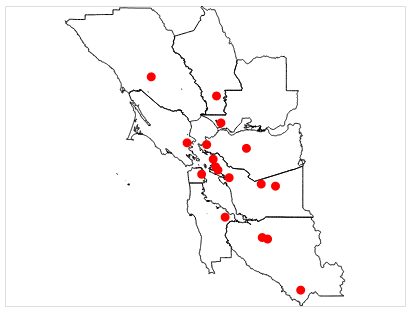

In [6]:
base_map + sites_map

#### Our PM 2.5 data consists of hourly measurements taken at 16 different stations from 1-1-2020 to 3-26-2020. First, we'll take the average measurement by day at each station, and then pivot the dataframe so that each date exists in it's own column. Then, we'll add the point location of each station to the PM 2.5 data.

In [7]:
# Reshape df, column per date
pm25_da = pm25_data[['site', 'date', 'value']].groupby(['site','date']).mean().reset_index()
pm25_da = pm25_da.pivot(index = 'site', values = 'value', columns = 'date').reset_index()
# Merge spatial data with aq data
pm25_gdf = pd.merge(gdf_sites, pm25_da, how = 'inner', on = 'site')
pm25_gdf.head()

,site,name,latitude,longitude,geometry,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,...,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31
0,2125,Redwood City,37.48293,-122.20348,POINT (-122.20348 37.48293),10.375000,5.250000,6.083333,7.947368,11.000000,...,4.833333,5.375000,2.565217,2.708333,3.833333,9.125000,9.833333,5.583333,2.130435,2.555556
1,2320,Gilroy-9th Street,36.99958,-121.57466,POINT (-121.57466 36.99958),10.416667,8.260870,6.333333,6.318182,6.833333,...,5.090909,3.500000,3.000000,3.625000,3.818182,6.260870,10.000000,5.260870,2.608696,1.666667
2,2373,San Francisco-Arkansas Street,37.76595,-122.39902,POINT (-122.39902 37.76595),9.041667,6.583333,9.375000,8.166667,9.416667,...,6.291667,6.666667,2.041667,1.625000,3.416667,7.347826,9.166667,5.583333,1.500000,0.777778
3,2410,Vallejo-304 Tuolumne Street,38.10251,-122.23800,POINT (-122.23800 38.10251),14.041667,6.458333,8.791667,7.916667,11.208333,...,0.875000,3.000000,3.739130,2.791667,4.666667,8.000000,10.333333,6.333333,2.083333,1.555556
4,2622,San Rafael,37.97230,-122.52011,POINT (-122.52011 37.97230),10.041667,6.500000,4.875000,6.208333,6.708333,...,NaN,5.727273,2.250000,1.333333,2.333333,7.750000,9.250000,4.916667,1.913043,1.222222


#### Given that the sensors are sparesly distributed across the Bay Area, we'll have to interpolate across the region. We'll start by interpolating our first date, 2-15-2020.

#### To interpolate spatially, we'll create a fine grid (detrmined by chosen pixel size) and use `scipy.griddata` to fill in the missing grid points according to the few measurements we do have. I follow the method laid out at [geologyandpython.com](http://geologyandpython.com/ml-interpolation-method.html) fairly closely.

In [8]:
# Create grid to interpolate across

# Define size of pixels in grid (units of lat/long degrees). Smaller pixels = smoother interpolation.
pixel = .05
# Determine extent of observations and create pixel_size-spaced arrays
# in the N and S direction
x_range = np.arange(pm25_gdf.longitude.min() - pm25_gdf.longitude.min() % pixel,
                    pm25_gdf.longitude.max(), pixel)
y_range = np.arange(pm25_gdf.latitude.min() - pm25_gdf.latitude.min() % pixel,
                    pm25_gdf.latitude.max(), pixel)[::-1]
shape = (len(y_range), len(x_range))
xmin, xmax, ymin, ymax = x_range.min(), x_range.max(), y_range.min(), y_range.max()
extent = (xmin, xmax, ymin, ymax)
# Create grid
x_mesh, y_mesh = np.meshgrid(x_range, y_range)


# Convert lat/long in gdf to grid indices (array indices)
pm25_gdf.loc[:, 'x_idx'] = ((pm25_gdf.longitude - xmin) / pixel).astype(int)
pm25_gdf.loc[:, 'y_idx'] = (shape[0] - ((pm25_gdf.latitude - ymin) / pixel)).astype(int)
pm25_array = np.zeros(shape)
pm25_array[:] = np.nan
# Add known values (sensor recordings) to grid
pm25_array[pm25_gdf.y_idx, pm25_gdf.x_idx] = pm25_gdf['2020-02-15']

#### Let's visualize the grid we created above. The only filled pixels should be where a sensor exists, so this should line up pretty closely with the sensor map above.

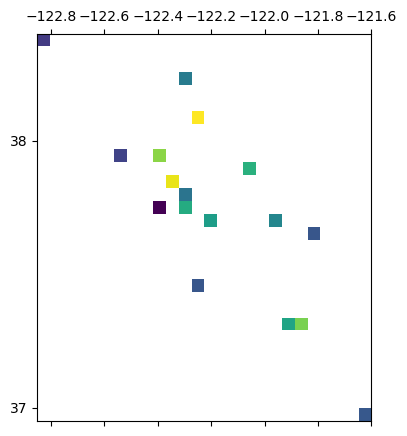

In [9]:
plt.matshow(pm25_array, extent=extent)
plt.gcf().set_size_inches(5,5)
plt.gcf().set_dpi(100)

#### Not too bad! There's some obvious spatial distortion, but we'll translate back to lat/long later. Now it's time to interpolate over those empty values. I'll use linear interpolation, which should yield estimates within the spatial boundaries of my existing points.

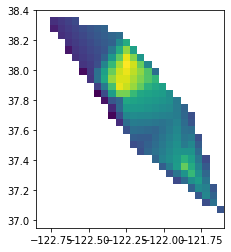

In [10]:
gridz0 = griddata((pm25_gdf['longitude'], pm25_gdf['latitude']), pm25_gdf['2020-02-15'], (x_mesh, y_mesh), method = 'linear')
plt.imshow(gridz0, extent=extent)

#### After playing around with pixel size, I settled on .05 to represent some level of detail without conveying too much confidence in my interpolation given that there are so few observations over such a wide area. I don't have any "ground truth" to test my interpolation against.

In [11]:
interp_df_feb15 = pd.DataFrame({'lat':y_mesh.flatten(), 'long': x_mesh.flatten(), 'value': gridz0.flatten()})
# Cast the results as a geodataframe
interp_gdf_feb15 = gpd.GeoDataFrame(
    interp_df_feb15, geometry=gpd.points_from_xy(interp_df_feb15.long, interp_df_feb15.lat))

#### Let's take a look at our interpolation:

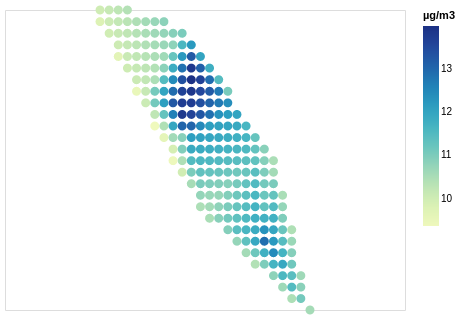

In [12]:
(alt.Chart(interp_gdf_feb15)
    .mark_geoshape()
    .encode(fill = alt.Color('value', 
                              title = 'µg/m3'),
            tooltip = [alt.Tooltip('value', title = 'PM 2.5 (µg/m3)', format = '0.5')]
                            ))

#### This looks pretty good! However, I'd like to remove the spacing between each grid point to get a smooth image across the area rather than distinct dots. To to this, I'll add a buffer around each point, and then create a square envelope around that circle to get a continuous grid. 

**source:** https://gis.stackexchange.com/questions/314949/creating-square-buffers-around-points-using-shapely

In [13]:
# Add a square buffer region around each interpolated point
gdft_feb15 = interp_gdf_feb15.copy()
buffer = gdft_feb15.buffer(0.04)
envelope = buffer.envelope
gdft_feb15['geometry'] = envelope

#### Now, let's look at the result!

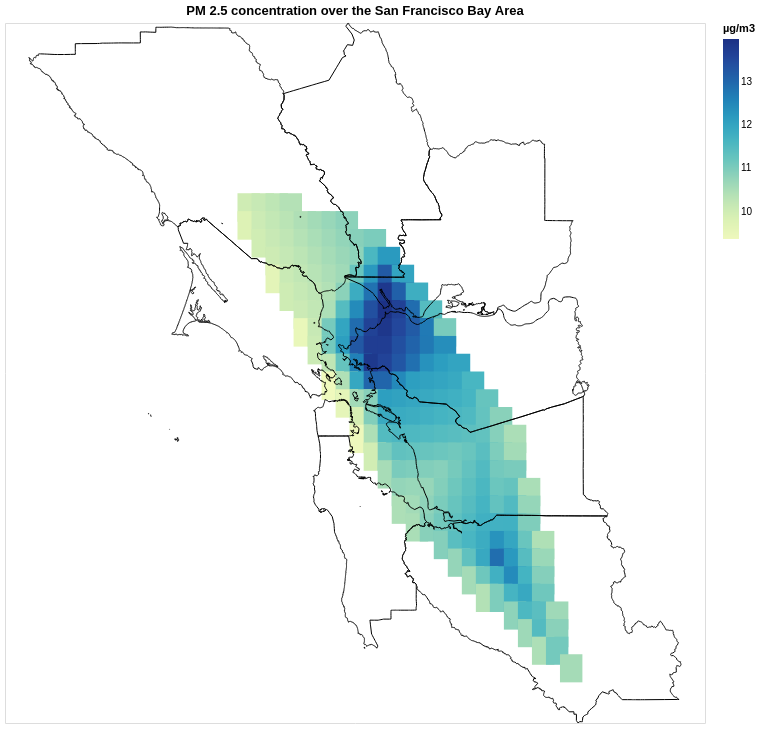

In [14]:
interpolated_plot = (alt.Chart(gdft_feb15)
                     .mark_geoshape()
                     .encode(fill = alt.Color('value', 
                                               title = 'µg/m3'),
                             tooltip = [alt.Tooltip('value', title = 'PM 2.5 (µg/m3)', format = '0.5')]
                            ))

((interpolated_plot + base_map)
 .properties(title = "PM 2.5 concentration over the San Francisco Bay Area", 
             width = 700, 
             height = 700))

Looks great! 

Now, we'll do the above operation for all dates 3-1-2020 to 3-26-2020.

In [17]:
# Create dataframe to store interpolated points in
interp_df = pd.DataFrame({'lat':y_mesh.flatten(), 'long': x_mesh.flatten()})

date_cols = pm25_gdf.columns[5:-2]
for date in date_cols:
    pm_interp = griddata((pm25_gdf['longitude'], pm25_gdf['latitude']), pm25_gdf[date], (x_mesh, y_mesh), method = 'linear')
    interp_df[date] = pm_interp.flatten()

# Cast to geodataframe
interp_gdf = gpd.GeoDataFrame(
    interp_df, geometry=gpd.points_from_xy(interp_df.long, interp_df.lat))

# Buffer each point to a square polygon
interp_gdf = gpd.GeoDataFrame(
    interp_df, geometry=gpd.points_from_xy(interp_df.long, interp_df.lat))

interp_buffer = interp_gdf.copy()
buffer = interp_buffer.buffer(0.04)
envelope = buffer.envelope
interp_buffer['geometry'] = envelope

interp_buffer.head()

,lat,long,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,...,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,geometry
0,38.4,-122.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-122.89000 38.36000, -122.81000 38.3..."
1,38.4,-122.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-122.84000 38.36000, -122.76000 38.3..."
2,38.4,-122.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-122.79000 38.36000, -122.71000 38.3..."
3,38.4,-122.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-122.74000 38.36000, -122.66000 38.3..."
4,38.4,-122.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-122.69000 38.36000, -122.61000 38.3..."


**Note:** You'll notice many NaN values in the above dataframe. This is expected, as only grid points that are within the bounds of the sensors will be interpolated. _Most_ of the frid points will be NaN on the outskirts of the dataframe (top, bottom, sides) but if you were to check the interior, you'll se many more filled values as a greater proportion of the center of the image is interpolated. 


#### Great! We have our interpolated values. Now, we'll do some wrangling to get our dataframe into a format conducive to plotting.

In [18]:
# We'll add a `date_int` column as well, which is very helpful for plotting
interp_buffer = interp_buffer.drop(columns = list(date_cols)[:15])
interp_buffer = interp_buffer.melt(id_vars = ['geometry','lat','long'], 
                                   var_name = 'date', 
                                   value_name = 'PM25HR')
interp_buffer['date_int'] = interp_buffer['date'].map(dict(zip(date_cols[15:], range(len(date_cols[15:])))))
interp_buffer.head()

,geometry,lat,long,date,PM25HR,date_int
0,"POLYGON ((-122.89000 38.36000, -122.81000 38.3...",38.4,-122.85,2020-03-01,NaN,0
1,"POLYGON ((-122.84000 38.36000, -122.76000 38.3...",38.4,-122.80,2020-03-01,NaN,0
2,"POLYGON ((-122.79000 38.36000, -122.71000 38.3...",38.4,-122.75,2020-03-01,NaN,0
3,"POLYGON ((-122.74000 38.36000, -122.66000 38.3...",38.4,-122.70,2020-03-01,NaN,0
4,"POLYGON ((-122.69000 38.36000, -122.61000 38.3...",38.4,-122.65,2020-03-01,NaN,0


#### Using ipywidgets, we can create an animation! Note that the **Shelter in Place** began at midnight on March 17th, 2020.

##### The animation below must be run locally in Jupyter Lab (github only supports static images). To run the animation:

1. Dowload/clone this repository
2. Navigate to the scripts folder via the command line
3. Open this notebook in Jupyter Lab
4. Check that you have `ipywidgets == 7.5.1`
        - `pip install ipywidgets`
5. **Uncomment `alt.renderers.enable('default')` and comment `alt.renderers.enable('png')` in the first cell**

**note:** Because Dash does not yet(?) support ipywidgets, the animation seen on the app is a gif of images exported from the plotting function below. This occurs in the `scripts/run_all.py` file, unlike the other plots which are rendered in the app (`app.py`).

In [20]:
# Note: the `param` variable is set to 'PM25HR' in the 3rd code cell

# Units and title mapping
param_title = {'OZONE': 'Ozone', 'NOX': 'NOx', 'PM25HR': 'PM 2.5', 'BC': 'Black Carbon'}
units_dict = {'OZONE': 'ppm', 'NOX': 'ppm', 'PM25HR': 'µg/m3', 'BC': 'µg/m3'}

h_aq, w_aq = 700, 700
@interact(
    date = widgets.Play(
        min=0,
        max=max(interp_buffer['date_int']),
        step = 1,
        interval = 1000,
        description="Press play",
        disabled=False)
    )
def plot_aq(date = 0):
    plot_df = interp_buffer.query('date_int =='+str(date)).reset_index(drop=True)
    interpolated_plot = (alt.Chart(plot_df)
                     .mark_geoshape()
                     .encode(fill = alt.Color(param,
                                              #sort = 'descending',
                                              scale = alt.Scale(domain = [min(interp_buffer[param].dropna()),
                                                                          max(interp_buffer[param].dropna())],
                                                               type = 'linear',
                                                               scheme = 'yelloworangebrown'),
                                               title = units_dict[param]
                                             ),
                             tooltip = [alt.Tooltip(param, 
                                                    title = param_title[param]+" "+units_dict[param], 
                                                    format = '0.5')]
                            ))
    if date < 16:
        return (interpolated_plot + base_map).properties(
            title = "Bay Area Avg. "+param_title[param]+" "+units_dict[param]+": "+plot_df.loc[0,'date'],
            height = 450,
            width = 500).configure_title(fontSize = 20).configure_legend(titleFontSize=16,labelFontSize = 14)
    else:
        annotation = alt.Chart(plot_df).mark_text(
            align='left',
            baseline='middle',
            fontSize = 16,
            dx = 65,
            dy = -210,
            text = 'Shelter-in-place enforced',
            color = 'red'
            ).encode()
        return (interpolated_plot + base_map + annotation).properties(
            title = "Bay Area Avg. "+param_title[param]+" "+units_dict[param]+": "+plot_df.loc[0,'date'],
            height = 450,
            width = 500).configure_title(fontSize = 20).configure_legend(titleFontSize=16, labelFontSize = 14)

interactive(children=(Play(value=0, description='Press play', interval=1000, max=30), Output()), _dom_classes=…

For our line plot of the PM 2.5 time series over the month, we don't need to consider interpolated values (only those from each station), and we'd like to incorporate all dates. We'll add columns for the **mean pollutant value** in the weeks leading up to shelter in place, and the time after the ordinance was enacted.

In [88]:
cols = ['name']+list(date_cols)
line_df = pm25_gdf[cols].melt(id_vars='name', 
    var_name = 'date', 
    value_name = param).dropna()
line_df['Pre-Shelter in place mean']=np.where(line_df['date']<='2020-03-16', 
                np.mean(line_df.query('date <= "2020-03-16"')[param]), np.nan)
line_df['Post-Shelter in place mean']=np.where(line_df['date']>'2020-03-16', 
                np.mean(line_df.query('date > "2020-03-16"')[param]), np.nan)

In [94]:
def plot_line(param='PM25HR'):
    lp = (alt.Chart(line_df).mark_line(size=1)
                .encode(
                    x=alt.X('date:T', title='',axis = alt.Axis(labelFontSize = 13)),
                    y=alt.Y(param, 
                            title = '{} ({})'.format(param_title[param],
                                                units_dict[param]),
                            axis = alt.Axis(labelFontSize = 16,
                            titleFontSize = 20)),
                    color=alt.Color('name:N', 
                                    title = 'Station'),
                    tooltip=['name:N'])
                .properties(height = 300, 
                            width = 900, 
                            title = 'Daily average {} concentration per station'.format(param_title[param])))
    pre_line = (alt.Chart(line_df)
        .mark_line(size=3, color='black')
        .encode(x='date:T',y='Pre-Shelter in place mean:Q'))
    post_line = (alt.Chart(line_df)
        .mark_line(size=3, color='black')
        .encode(x='date:T',y='Post-Shelter in place mean:Q'))
    text = alt.Chart().mark_text(dx=240,
                                dy=-130,
                                size=18,
                                text='Black = Mean value Pre- and Post- Shelter in Place').encode()
    return ((lp + pre_line + post_line + text)
                .configure_title(fontSize = 24)
                .configure_legend(titleFontSize=16))

plot_line()

alt.LayerChart(...)

## Sources

#### Data

- https://data.sfgov.org/Geographic-Locations-and-Boundaries/Bay-Area-Counties/s9wg-vcph
- https://www.arb.ca.gov

#### Code resources

- https://gis.stackexchange.com/questions/314949/creating-square-buffers-around-points-using-shapely
- http://geologyandpython.com/ml-interpolation-method.html